In [4]:
import os
import time
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
from scipy.io import loadmat

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Model

In [5]:
convNext = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

class CSRNet(nn.Module):

    def __init__(self):

        super().__init__()
        self.frontend = nn.Sequential(
            convNext.features[0:4],
            nn.Conv2d(192, 512, kernel_size=1)
        )

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )
    

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 191MB/s] 


In [6]:
model = CSRNet()
model = model.to(device)

# Dataset Pipeline

In [7]:
k_nearest = 3
beta = 0.3

def generate_density_map(img, points):

    img_width, img_height = img.size
    d_map_height = img_height // 8
    d_map_width = img_width // 8
    density_map = np.zeros((d_map_height, d_map_width), dtype=np.float32)
    
    if len(points) == 0:
        return density_map

    scaled_points = points / 8
    
    sigmas = []
    if len(scaled_points) > 1:
        distances = cdist(scaled_points, scaled_points)
        
        for i in range(len(scaled_points)):
            sorted_distances = np.sort(distances[i][distances[i] > 1e-6])
            
            if len(sorted_distances) >= k_nearest:
                d_k = sorted_distances[k_nearest - 1]
                sigma_i = beta * d_k
            else:
                sigma_i = beta * np.mean(sorted_distances) if len(sorted_distances) > 0 else 1.0
            sigmas.append(sigma_i)
    else:
        sigmas.append(4.0)
    
    sigmas = np.array(sigmas)
    
    for i, (x, y) in enumerate(scaled_points):
        if int(y) < d_map_height and int(x) < d_map_width:
            point_map = np.zeros_like(density_map)
            point_map[int(y), int(x)] = 1.0
            
            blurred_point_map = gaussian_filter(point_map, sigma=sigmas[i], mode='constant')

            density_map += blurred_point_map
    
    return density_map

In [8]:
class CustomDataset(Dataset):

    def __init__(self, img_folder_path, point_folder_path):
        self.img_folder_path = img_folder_path
        self.point_folder_path = point_folder_path
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


    def __len__(self):
        return(len(os.listdir(self.img_folder_path)))


    def __getitem__(self, index):
        img_path = os.path.join(self.img_folder_path, f"IMG_{index+1}.jpg")
        point_path = os.path.join(self.point_folder_path, f"GT_IMG_{index+1}.mat")

        img = Image.open(img_path).convert("RGB")

        data = loadmat(point_path)
        point = data["image_info"][0][0][0][0][0]

        density_map = generate_density_map(img, points=point.astype(int))
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        img = self.transform(img)

        return img, density_map

In [9]:
train_dataset = CustomDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images", "/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth")
test_dataset = CustomDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/images", "/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/ground_truth")

In [10]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

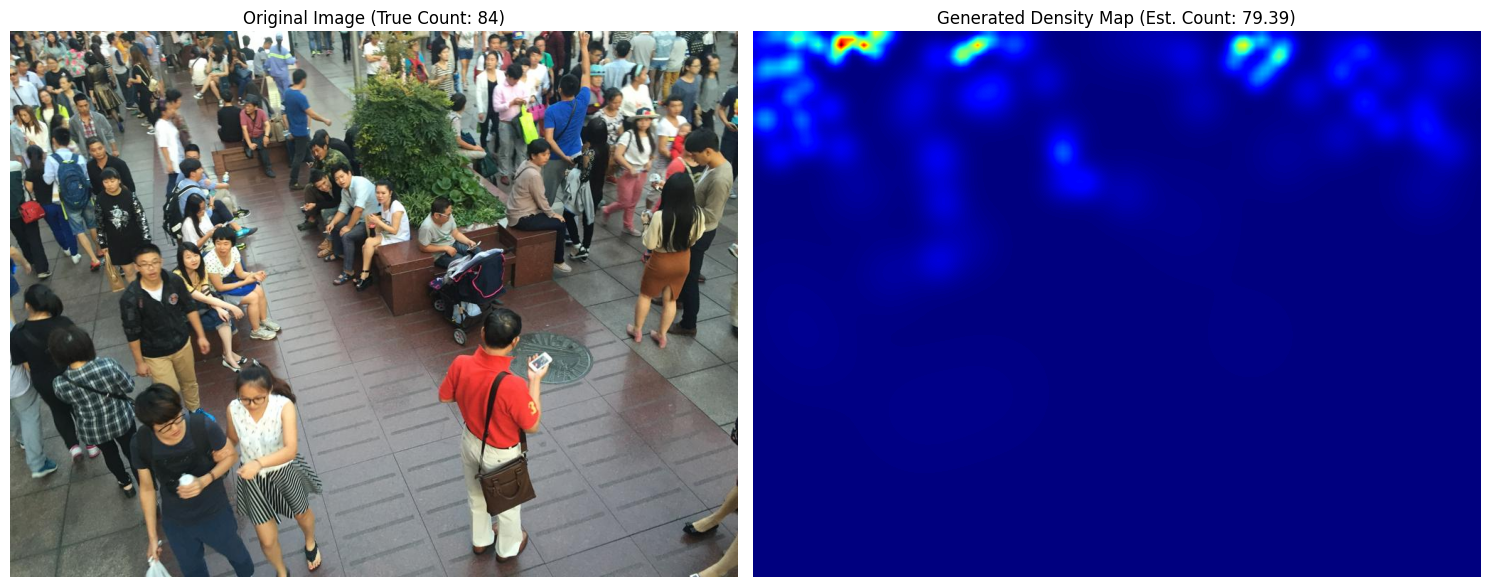

In [11]:
data = loadmat('/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth/GT_IMG_40.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images/IMG_40.jpg").convert("RGB")

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)

upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Loss Fxn

In [13]:
learning_rate = 0.0001
epochs = 1

loss_fxn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [48]:
start = time.time()
model.train()
losses = []


for i in range(epochs):

    total_epoch_loss = 0
    count = 0

    for batch_image, batch_density_map in train_loader:

        batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)
        # print(time.time())

        output = model(batch_image)
        # print(time.time())

        loss = loss_fxn(output, batch_density_map)
        # print(time.time())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(time.time())
        count += 1
        print(f"Batch No.: {count}, Time Elapsed: {(time.time() - start):.2f}")
    
        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    print(f"Epoch: {i+1}, Loss: {avg_epoch_loss}")        

Batch No.: 1, Time Elapsed: 1.14
Batch No.: 2, Time Elapsed: 4.95
Batch No.: 3, Time Elapsed: 8.80
Batch No.: 4, Time Elapsed: 12.65
Batch No.: 5, Time Elapsed: 16.50
Batch No.: 6, Time Elapsed: 20.36
Batch No.: 7, Time Elapsed: 24.20
Batch No.: 8, Time Elapsed: 28.06
Batch No.: 9, Time Elapsed: 31.90
Batch No.: 10, Time Elapsed: 35.73
Batch No.: 11, Time Elapsed: 39.58
Batch No.: 12, Time Elapsed: 43.43
Batch No.: 13, Time Elapsed: 47.30
Batch No.: 14, Time Elapsed: 51.16
Batch No.: 15, Time Elapsed: 55.01
Batch No.: 16, Time Elapsed: 58.87
Batch No.: 17, Time Elapsed: 62.73
Batch No.: 18, Time Elapsed: 66.59
Batch No.: 19, Time Elapsed: 70.44
Batch No.: 20, Time Elapsed: 74.32
Batch No.: 21, Time Elapsed: 78.17
Batch No.: 22, Time Elapsed: 82.02
Batch No.: 23, Time Elapsed: 85.87
Batch No.: 24, Time Elapsed: 89.74
Batch No.: 25, Time Elapsed: 93.59
Batch No.: 26, Time Elapsed: 97.45
Batch No.: 27, Time Elapsed: 101.29
Batch No.: 28, Time Elapsed: 105.16
Batch No.: 29, Time Elapsed: 1

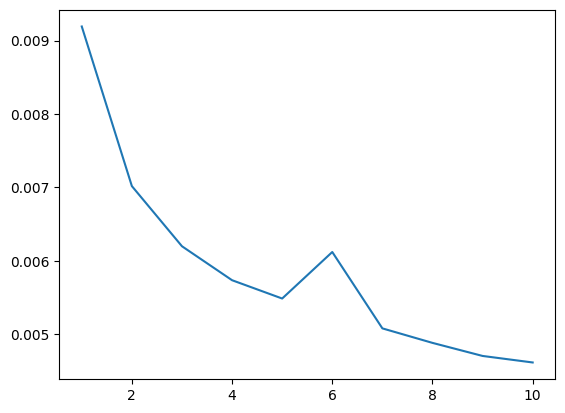

In [27]:
plt.plot(range(1, 11), losses)
plt.show()

In [46]:
torch.save(model.state_dict(), 'model_weights_CSRNet+ConvNeXT14.pth')

In [12]:
model = CSRNet()
model = model.to(device)
model.load_state_dict(torch.load('/kaggle/input/csrnetconvnext12/pytorch/default/1/model_weights_CSRNetConvNeXT12.pth'))

<All keys matched successfully>

# Evaluation

In [14]:
model.eval()

CSRNet(
  (frontend): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-

In [15]:
total_loss = 0
total_mae = 0
total_mse = 0
count = 0

for batch_image, batch_density_map in test_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = loss_fxn(output, batch_density_map)

    predicted_counts = output.sum(dim=[1, 2, 3])
    true_counts = batch_density_map.sum(dim=[1, 2, 3])

    abs_diff = torch.abs(predicted_counts - true_counts)
    squared_diff = (predicted_counts - true_counts) ** 2
    
    total_mae += torch.sum(abs_diff).item()
    total_mse += torch.sum(squared_diff).item()

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / (len(test_loader))
avg_mae = total_mae / (len(test_loader) * batch_size)
avg_mse = total_mse / (len(test_loader) * batch_size)

print(f"Avg Loss: {avg_loss}") 
print(f"Avg MAE: {avg_mae}")
print(f"Avg MSE: {avg_mse}")

Batch No.: 1, Loss: 0.002354927361011505
Batch No.: 2, Loss: 0.00518419174477458
Batch No.: 3, Loss: 0.007277970667928457
Batch No.: 4, Loss: 0.0041688671335577965
Batch No.: 5, Loss: 0.005812884774059057
Batch No.: 6, Loss: 0.002545975148677826
Batch No.: 7, Loss: 0.004174089524894953
Batch No.: 8, Loss: 0.0041532618924975395
Batch No.: 9, Loss: 0.004537515342235565
Batch No.: 10, Loss: 0.01185497548431158
Batch No.: 11, Loss: 0.002847438445314765
Batch No.: 12, Loss: 0.004005696624517441
Batch No.: 13, Loss: 0.0038344599306583405
Batch No.: 14, Loss: 0.008027555420994759
Batch No.: 15, Loss: 0.004310024436563253
Batch No.: 16, Loss: 0.0031568470876663923
Batch No.: 17, Loss: 0.00390932522714138
Batch No.: 18, Loss: 0.003975301049649715
Batch No.: 19, Loss: 0.007118730805814266
Batch No.: 20, Loss: 0.007312131579965353
Batch No.: 21, Loss: 0.003364946460351348
Batch No.: 22, Loss: 0.0043382528237998486
Batch No.: 23, Loss: 0.0040792254731059074
Batch No.: 24, Loss: 0.00444839848205447

In [16]:
total_loss = 0
total_mae = 0
total_mse = 0
count = 0

for batch_image, batch_density_map in train_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = loss_fxn(output, batch_density_map)

    predicted_counts = output.sum(dim=[1, 2, 3])
    true_counts = batch_density_map.sum(dim=[1, 2, 3])

    abs_diff = torch.abs(predicted_counts - true_counts)
    squared_diff = (predicted_counts - true_counts) ** 2
    
    total_mae += torch.sum(abs_diff).item()
    total_mse += torch.sum(squared_diff).item()

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / (len(train_loader))
avg_mae = total_mae / (len(train_loader) * batch_size)
avg_mse = total_mse / (len(train_loader) * batch_size)

print(f"Avg Loss: {avg_loss}")
print(f"Avg MAE: {avg_mae}")
print(f"Avg MSE: {avg_mse}")

Batch No.: 1, Loss: 0.004561595153063536
Batch No.: 2, Loss: 0.0032642127480357885
Batch No.: 3, Loss: 0.003958575427532196
Batch No.: 4, Loss: 0.0020035021007061005
Batch No.: 5, Loss: 0.006303776055574417
Batch No.: 6, Loss: 0.0038861152715981007
Batch No.: 7, Loss: 0.003872637404128909
Batch No.: 8, Loss: 0.006818633526563644
Batch No.: 9, Loss: 0.0040132650174200535
Batch No.: 10, Loss: 0.003928080201148987
Batch No.: 11, Loss: 0.0033937525004148483
Batch No.: 12, Loss: 0.003756526857614517
Batch No.: 13, Loss: 0.003412610851228237
Batch No.: 14, Loss: 0.004149056505411863
Batch No.: 15, Loss: 0.0034670322202146053
Batch No.: 16, Loss: 0.004110468551516533
Batch No.: 17, Loss: 0.004175001755356789
Batch No.: 18, Loss: 0.003496504155918956
Batch No.: 19, Loss: 0.0026082340627908707
Batch No.: 20, Loss: 0.004618207924067974
Batch No.: 21, Loss: 0.0015627406537532806
Batch No.: 22, Loss: 0.002593705430626869
Batch No.: 23, Loss: 0.0036060400307178497
Batch No.: 24, Loss: 0.00796187575

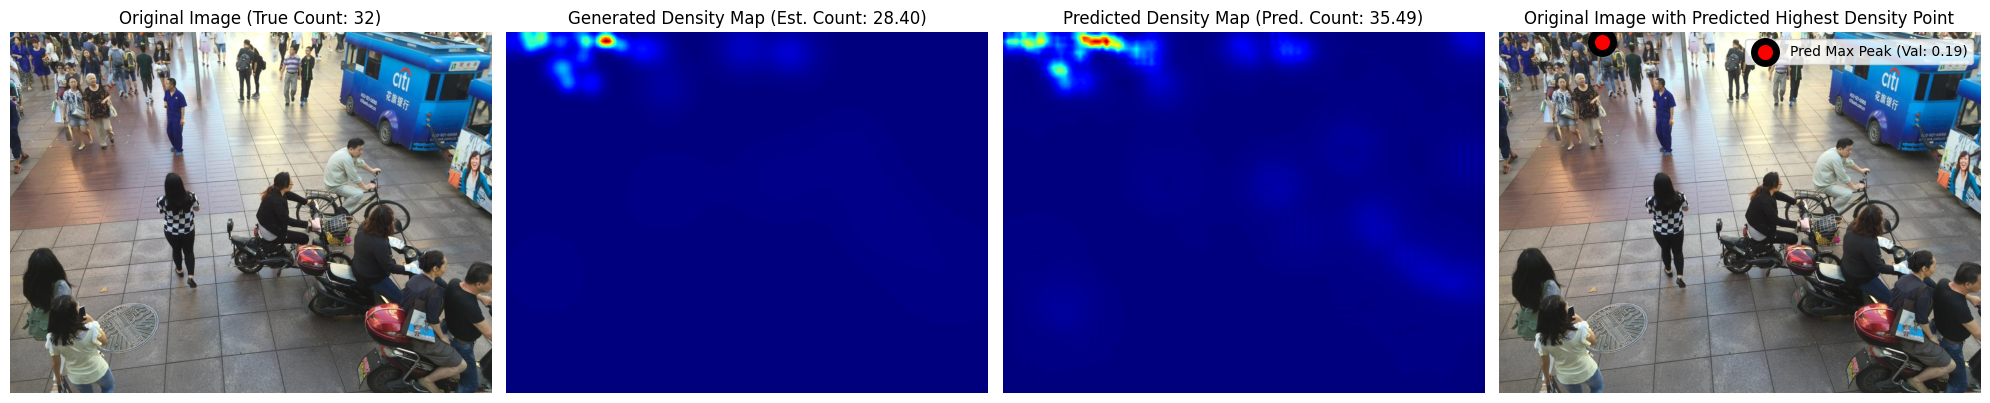

In [20]:
from scipy.ndimage import maximum_filter


data = loadmat('/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth/GT_IMG_36.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images/IMG_36.jpg").convert("RGB")
width, height = img.size

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)
upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
with torch.no_grad():
    img_ = transform(img)
    img_ = img_.to(device)
    predicted_density_map = model(img_.unsqueeze(0))
    upsampled_predicted_density_map = torch.nn.functional.interpolate(
        predicted_density_map,
        size=(height, width),
        mode='bilinear',
        align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)
predicted_count = predicted_density_map.sum().item()


max_pred_density_value = np.max(upsampled_predicted_density_map)
max_pred_density_coords_flat = np.argmax(upsampled_predicted_density_map)
max_pred_density_peak_row, max_pred_density_peak_col = np.unravel_index(
    max_pred_density_coords_flat, upsampled_predicted_density_map.shape
)


plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(upsampled_predicted_density_map, cmap='jet')
plt.title(f'Predicted Density Map (Pred. Count: {predicted_count:.2f})')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img)
plt.scatter(max_pred_density_peak_col, max_pred_density_peak_row, 
            color='red', s=1000, marker='.', edgecolors='black', linewidth=5, 
            label=f'Pred Max Peak (Val: {max_pred_density_value:.2f})')
plt.title(f'Original Image with Predicted Highest Density Point')
plt.axis('off')
plt.legend()

plt.tight_layout()
plt.show()